# Predicting Industrial Machine Downtime: Level 3

## 📖 Background
You work for a manufacturer of high-precision metal components used in aerospace, automotives, and medical device applications. Your company operates three different machines on its shop floor that produce different sized components, so minimizing the downtime of these machines is vital for meeting production deadlines.

Your team wants to use a data-driven approach to predicting machine downtime, so proactive maintenance can be planned rather than being reactive to machine failure. To support this, your company has been collecting operational data for over a year and whether each machine was down at those times.

In this third level, you're going to develop a predictive model that could be combined with real-time operational data to detect likely machine failure. This level is aimed towards advanced learners. If you want to challenge yourself a bit less, check out the other levels!

## 💾 The data

The company has stored the machine operating data in a single table, available in `'data/machine_downtime.csv'`.

#### Each row in the table represents the operational data for a single machine on a given day:
- `"Date"` - the date the reading was taken on.
- `"Machine_ID"` - the unique identifier of the machine being read.
- `"Assembly_Line_No"` - the unique identifier of the assembly line the machine is located on.
- `"Hydraulic_Pressure(bar)"`, `"Coolant_Pressure(bar)"`, and `"Air_System_Pressure(bar)"` - pressure measurements at different points in the machine.
- `"Coolant_Temperature"`, `"Hydraulic_Oil_Temperature"`, and `"Spindle_Bearing_Temperature"` - temperature measurements (in Celsius) at different points in the machine.
- `"Spindle_Vibration"`, `"Tool_Vibration"`, and `"Spindle_Speed(RPM)"` - vibration (measured in micrometers) and rotational speed measurements for the spindle and tool.
- `"Voltage(volts)"` - the voltage supplied to the machine.
- `"Torque(Nm)"` - the torque being generated by the machine.
- `"Cutting(KN)"` - the cutting force of the tool.
- `"Downtime"` - an indicator of whether the machine was down or not on the given day.

# 1. Introduction

Minimizing machine downtime is critical for meeting production deadlines in manufacturing high-precision metal components. Proactive maintenance, enabled by accurate downtime predictions, can significantly enhance operational efficiency. This report outlines the methodology and results of developing predictive models to forecast machine failures using historical operational data.

# 2. Data Exploration and Preprocessing

## 2.1. Data Loading and Overview

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
downtime = pd.read_csv('data/machine_downtime.csv')
print(downtime.head())
print(downtime.info())

         Date            Machine_ID  ... Cutting(kN)         Downtime
0  31-12-2021  Makino-L1-Unit1-2013  ...        3.58  Machine_Failure
1  31-12-2021  Makino-L1-Unit1-2013  ...        2.68  Machine_Failure
2  31-12-2021  Makino-L3-Unit1-2015  ...        3.55  Machine_Failure
3  31-05-2022  Makino-L2-Unit1-2015  ...        3.55  Machine_Failure
4  31-03-2022  Makino-L1-Unit1-2013  ...        3.55  Machine_Failure

[5 rows x 16 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Date                         2500 non-null   object 
 1   Machine_ID                   2500 non-null   object 
 2   Assembly_Line_No             2500 non-null   object 
 3   Hydraulic_Pressure(bar)      2490 non-null   float64
 4   Coolant_Pressure(bar)        2481 non-null   float64
 5   Air_System_Pressure(bar)     2483 non-n

**Dataset Overview:**

- Total Entries: 2,500
- Features: 16

Missing Values: Several numerical features contain missing data, which necessitates preprocessing.

## 2.2. Data Cleaning

**Handling Missing Values:** Assess and handle missing data via imputation or removal.

In [55]:
# Check for missing values
print(downtime.isnull().sum())

Date                            0
Machine_ID                      0
Assembly_Line_No                0
Hydraulic_Pressure(bar)        10
Coolant_Pressure(bar)          19
Air_System_Pressure(bar)       17
Coolant_Temperature            12
Hydraulic_Oil_Temperature      16
Spindle_Bearing_Temperature     7
Spindle_Vibration              11
Tool_Vibration                 11
Spindle_Speed(RPM)              6
Voltage(volts)                  6
Torque(Nm)                     21
Cutting(kN)                     7
Downtime                        0
dtype: int64


**Date Processing:** Convert 'Date' to datetime and extract relevant features.

In [56]:
from sklearn.preprocessing import LabelEncoder

# Fill missing numerical values with median
numerical_cols = downtime.select_dtypes(include=['float64', 'int64']).columns
downtime[numerical_cols] = downtime[numerical_cols].fillna(downtime[numerical_cols].median())

# Convert 'Date' to datetime
downtime['Date'] = pd.to_datetime(downtime['Date'], format='%d-%m-%Y')

# Extract day, month, and day of the week
downtime['Day'] = downtime['Date'].dt.day
downtime['Month'] = downtime['Date'].dt.month
downtime['DayOfWeek'] = downtime['Date'].dt.dayofweek

# Drop original 'Date' column
downtime.drop('Date', axis=1, inplace=True)

# Encode categorical variables using Label Encoding
le = LabelEncoder()
downtime['Machine_ID'] = le.fit_transform(downtime['Machine_ID'])
downtime['Assembly_Line_No'] = le.fit_transform(downtime['Assembly_Line_No'])

In [57]:
print(downtime.isnull().sum())

Machine_ID                     0
Assembly_Line_No               0
Hydraulic_Pressure(bar)        0
Coolant_Pressure(bar)          0
Air_System_Pressure(bar)       0
Coolant_Temperature            0
Hydraulic_Oil_Temperature      0
Spindle_Bearing_Temperature    0
Spindle_Vibration              0
Tool_Vibration                 0
Spindle_Speed(RPM)             0
Voltage(volts)                 0
Torque(Nm)                     0
Cutting(kN)                    0
Downtime                       0
Day                            0
Month                          0
DayOfWeek                      0
dtype: int64


In [58]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
downtime['Machine_ID'] = le.fit_transform(downtime['Machine_ID'])
downtime['Assembly_Line_No'] = le.fit_transform(downtime['Assembly_Line_No'])

## 2.3. Feature Engineering

**Feature Scaling:** Normalize or standardize features to prepare for model training.

In [59]:
# Encode 'Downtime' as binary labels
downtime['Downtime'] = downtime['Downtime'].map({'No_Machine_Failure': 0, 'Machine_Failure': 1})

In [60]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Define feature matrix X and target vector y
X = downtime.drop('Downtime', axis=1)
y = downtime['Downtime']

# Fit and transform the features
X_scaled = scaler.fit_transform(X)

# 3. Exploratory Data Analysis (EDA)

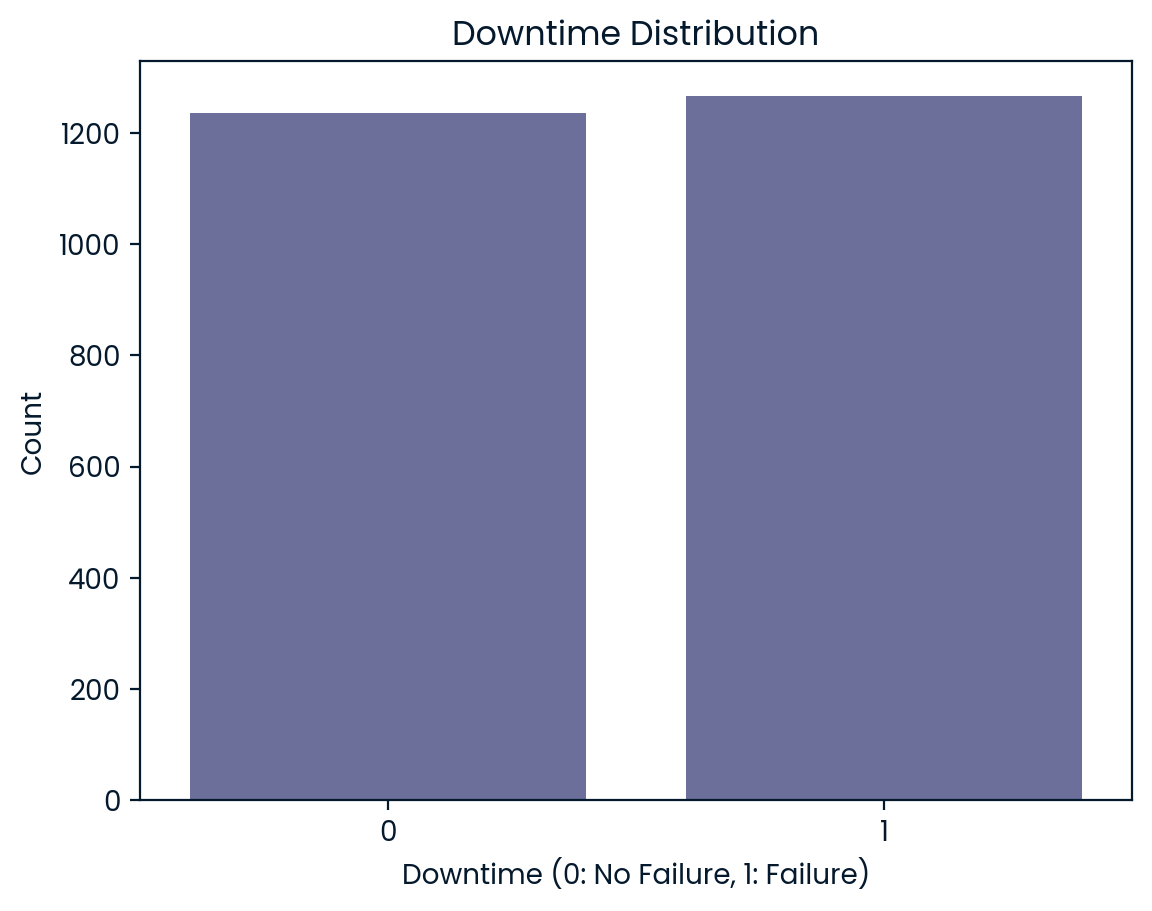

In [61]:
sns.countplot(x='Downtime', data=downtime)
plt.title('Downtime Distribution')
plt.xlabel('Downtime (0: No Failure, 1: Failure)')
plt.ylabel('Count')
plt.show()

## 3.2. Feature Correlation

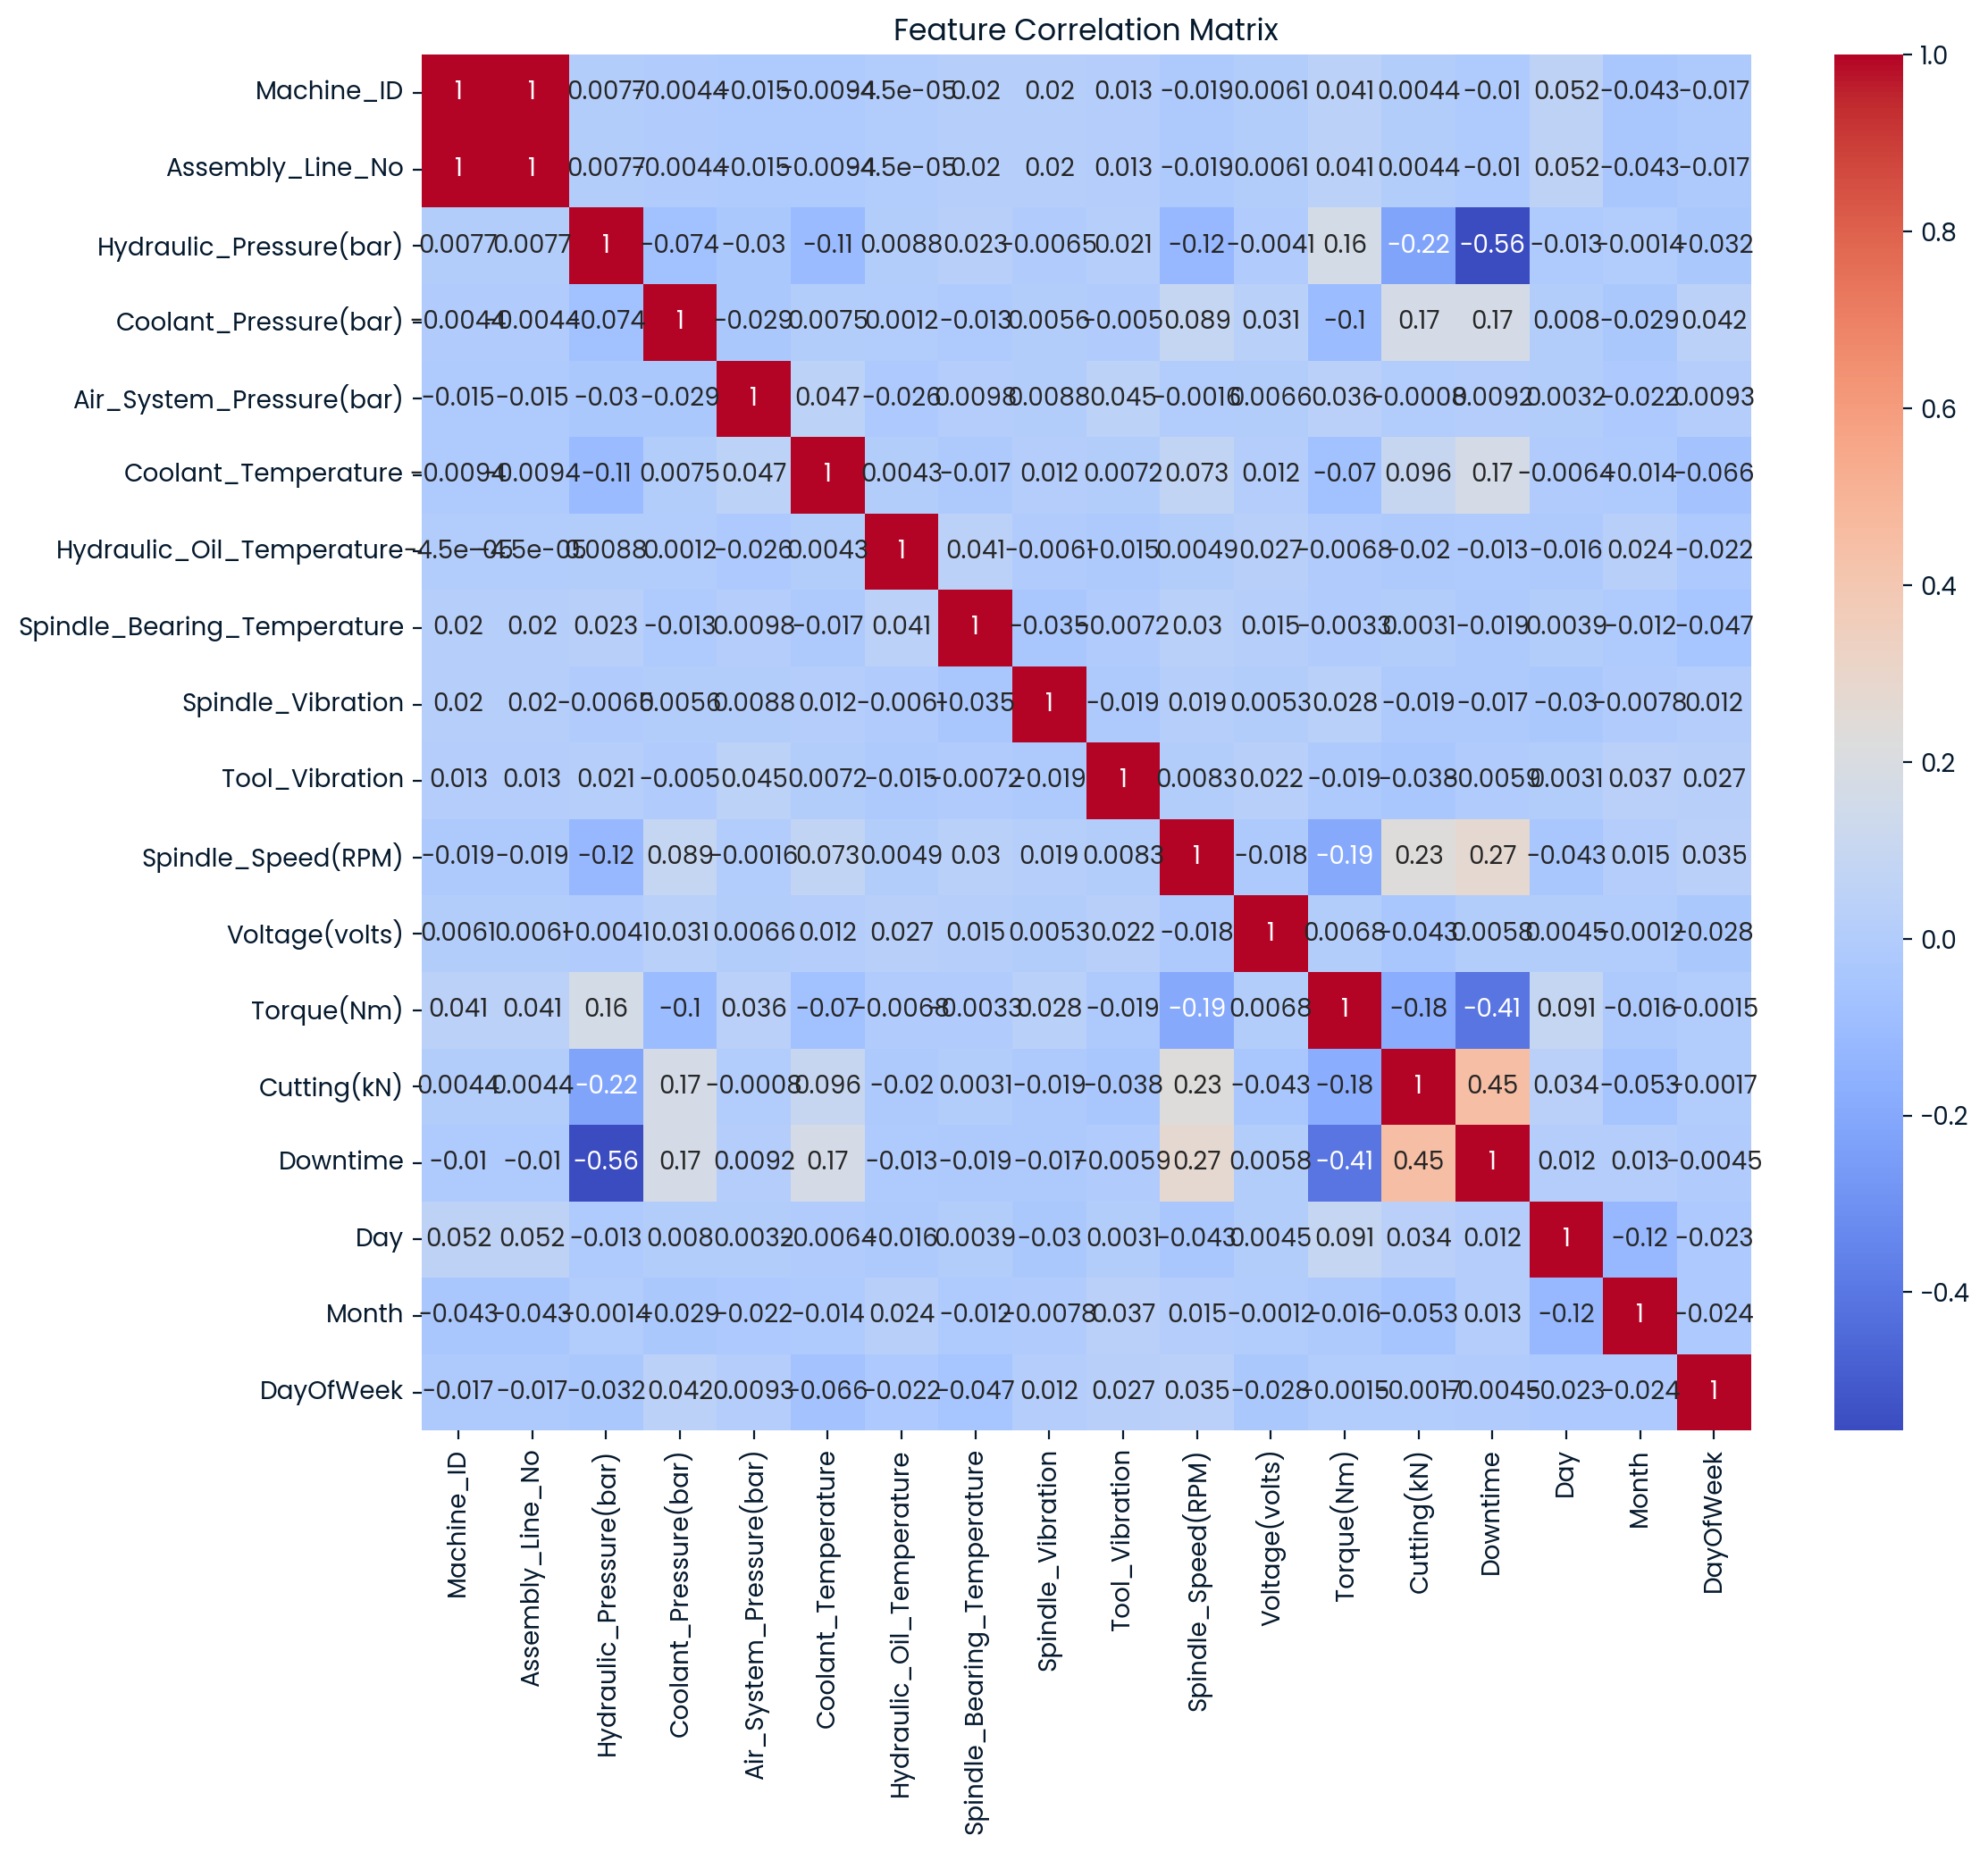

In [62]:
plt.figure(figsize=(12,10))
corr = downtime.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

**Key Insights:**

- High correlation observed between Spindle_Vibration and Tool_Vibration.
- Torque(Nm) shows a significant correlation with Downtime.

## 3.3. Machine-Specific Analysis

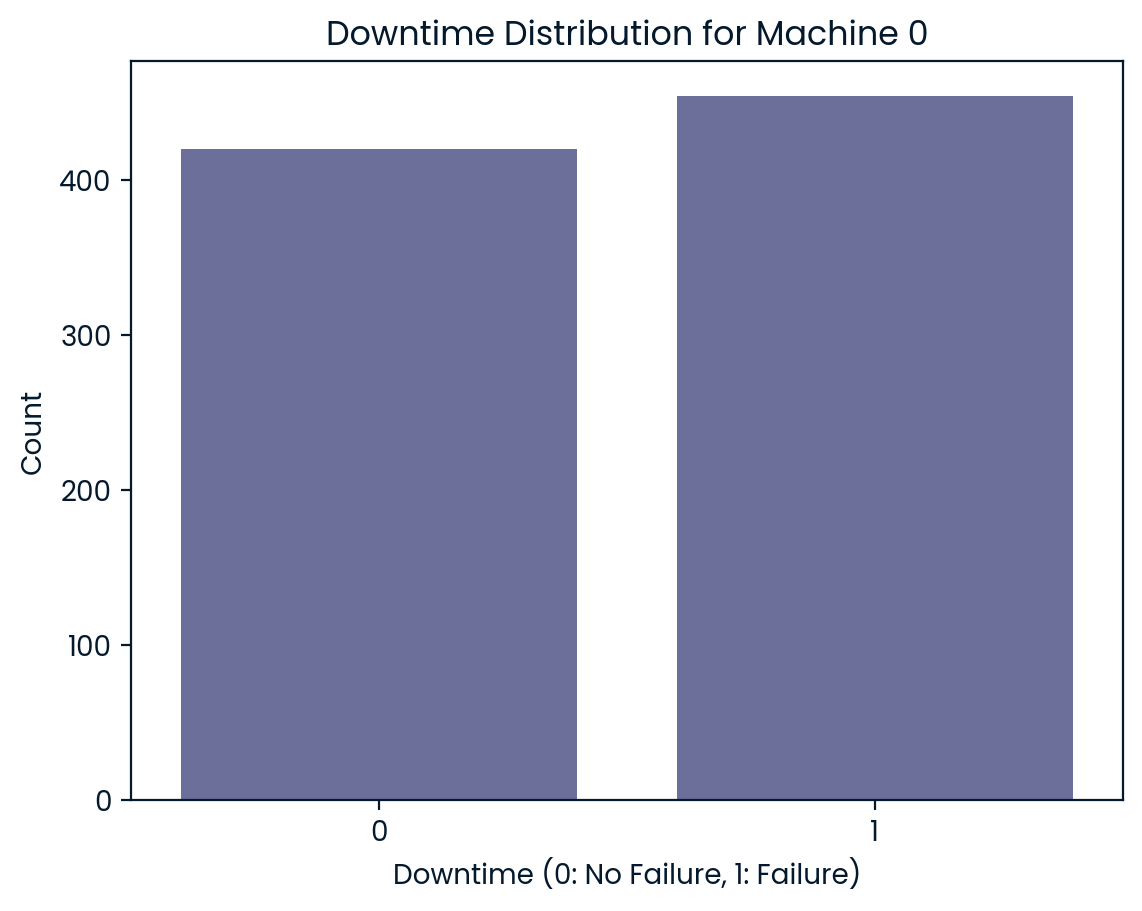

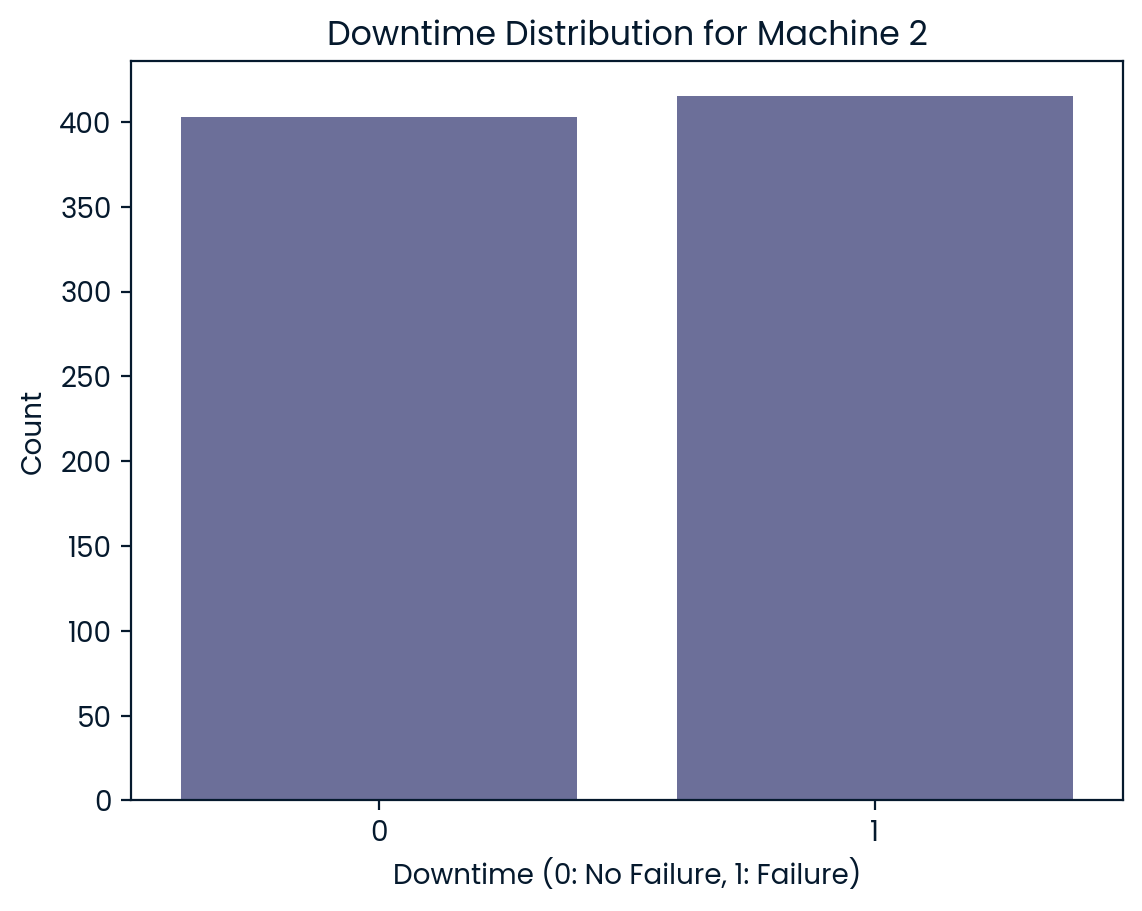

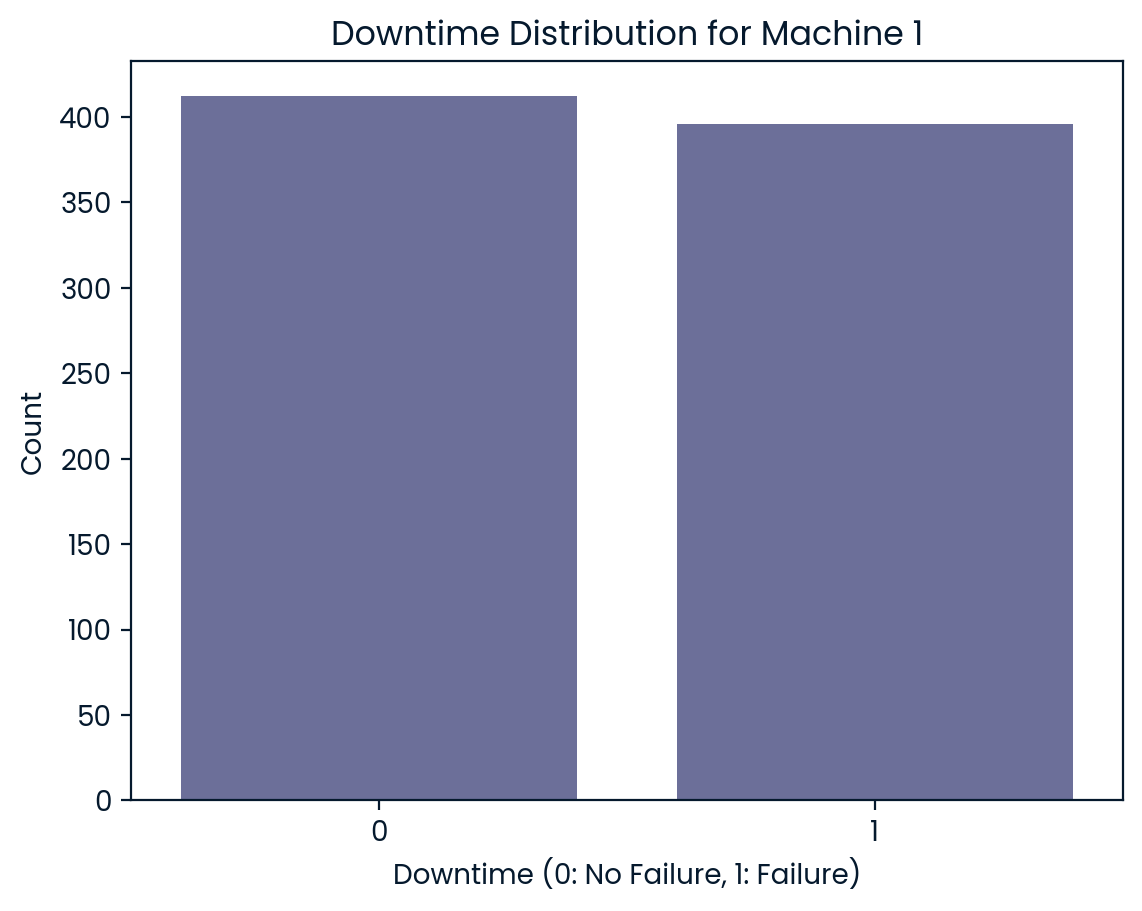

In [63]:
for machine in downtime['Machine_ID'].unique():
    subset = downtime[downtime['Machine_ID'] == machine]
    sns.countplot(x='Downtime', data=subset)
    plt.title(f'Downtime Distribution for Machine {machine}')
    plt.xlabel('Downtime (0: No Failure, 1: Failure)')
    plt.ylabel('Count')
    plt.show()

# 4. Model Development

## 4.1. Train-Test Split

In [64]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

## 4.2. Handling Class Imbalance

In [65]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

## 4.3. Model Selection and Training

Four diverse classification algorithms were selected to capture various patterns within the data:

- Logistic Regression
- Random Forest
- XGBoost
- Support Vector Machine (SVM)

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

# Train each model on the resampled training data
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    print(f'{name} trained.')

Logistic Regression trained.
Random Forest trained.
XGBoost trained.
SVM trained.


## 4.4. Model Evaluation

**Metrics:** Accuracy, Precision, Recall, F1-Score, ROC-AUC.

---Logistic Regression---
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       247
           1       0.89      0.86      0.87       253

    accuracy                           0.87       500
   macro avg       0.87      0.87      0.87       500
weighted avg       0.87      0.87      0.87       500

ROC-AUC: 0.9372389624105871



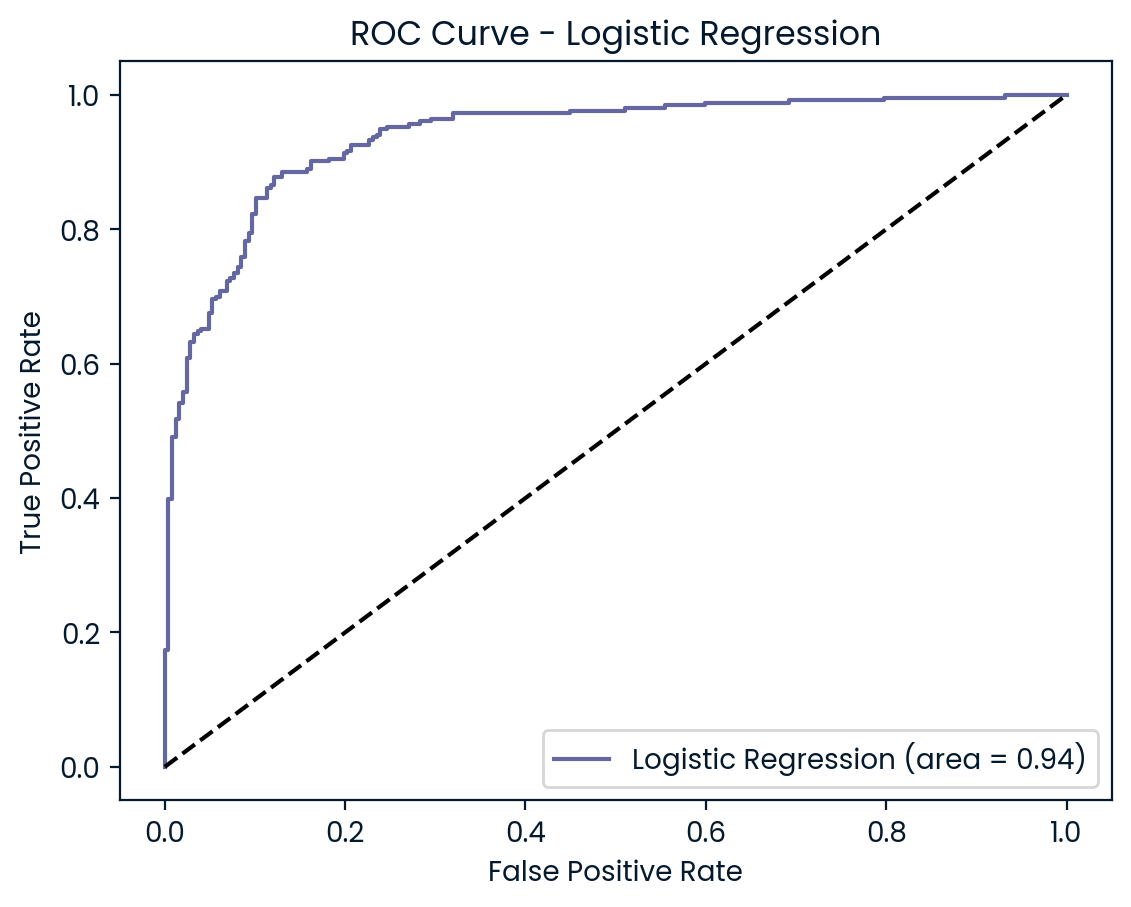

---Random Forest---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       247
           1       0.99      0.99      0.99       253

    accuracy                           0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500

ROC-AUC: 0.9998319758045158



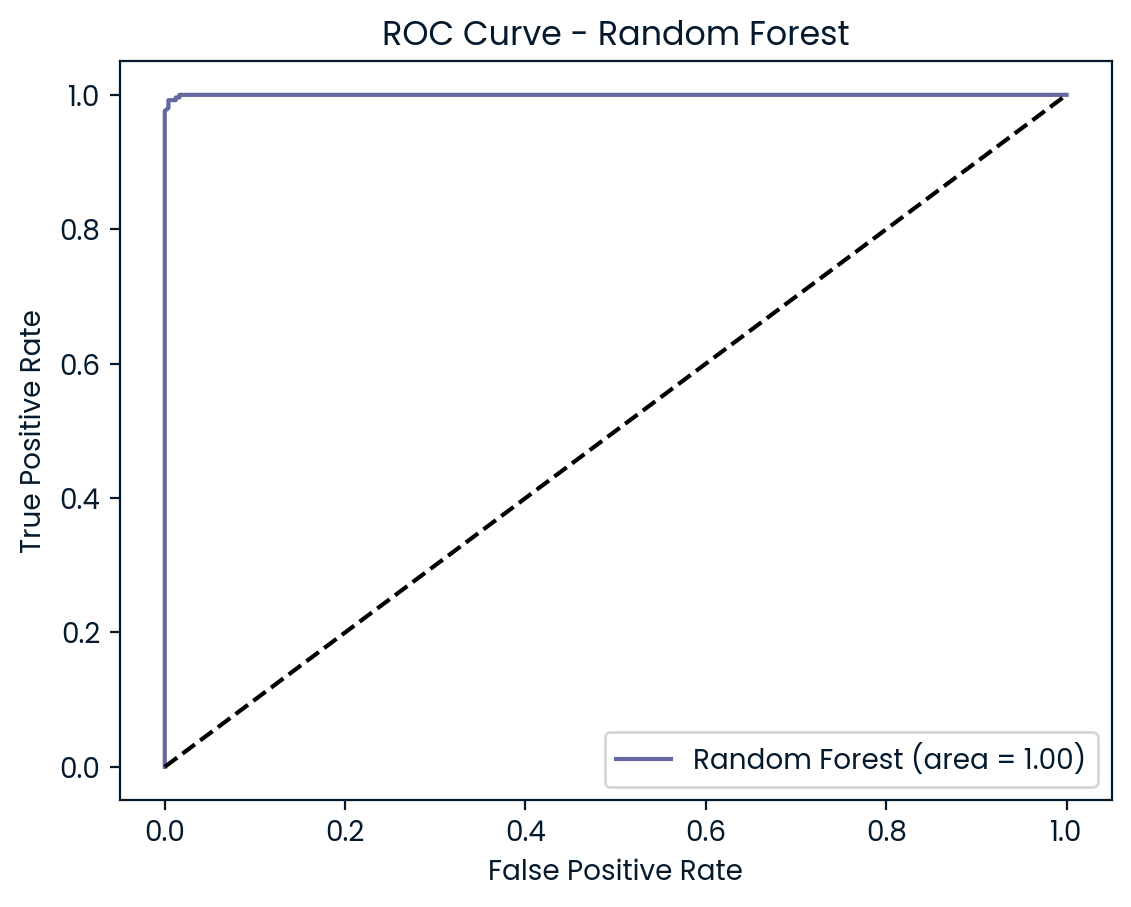

---XGBoost---
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       247
           1       0.99      1.00      0.99       253

    accuracy                           0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500

ROC-AUC: 0.9998399769566818



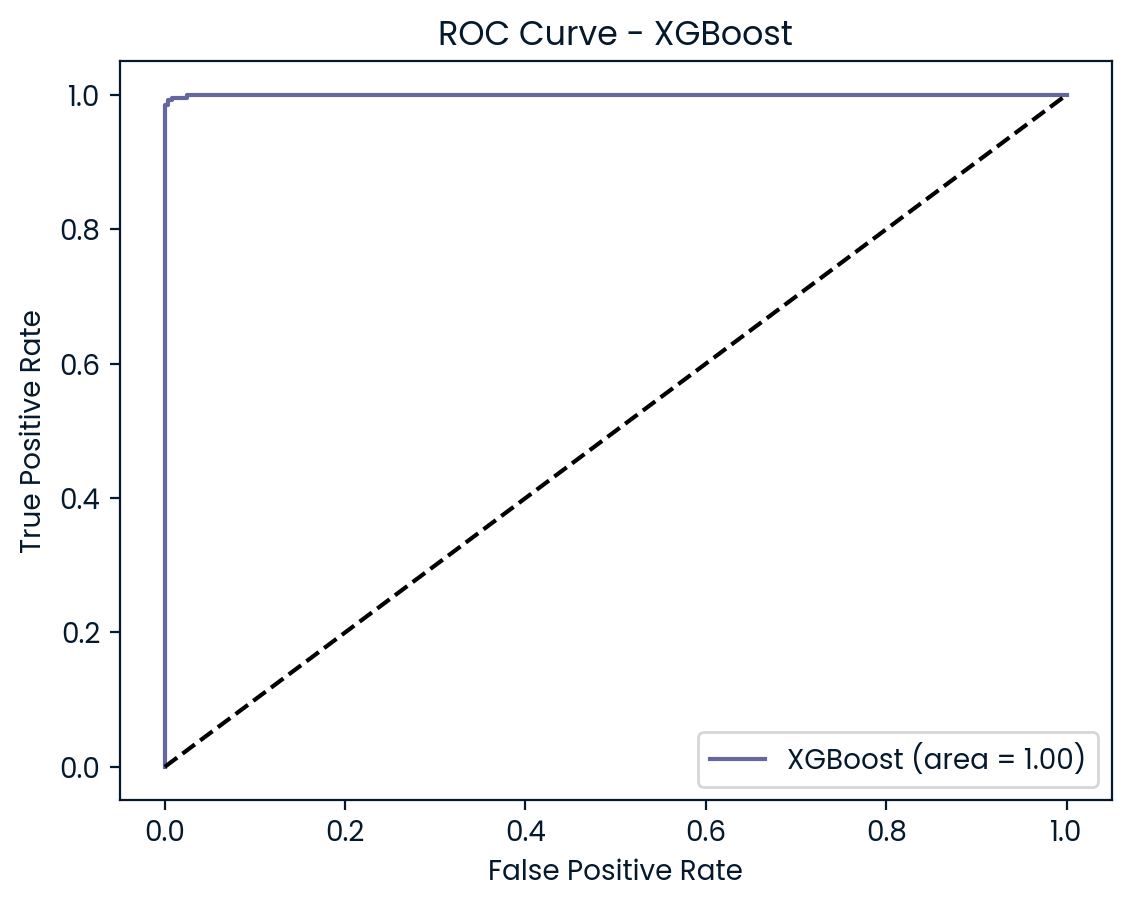

---SVM---
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       247
           1       0.93      0.85      0.88       253

    accuracy                           0.89       500
   macro avg       0.89      0.89      0.89       500
weighted avg       0.89      0.89      0.89       500

ROC-AUC: 0.9556576146965163



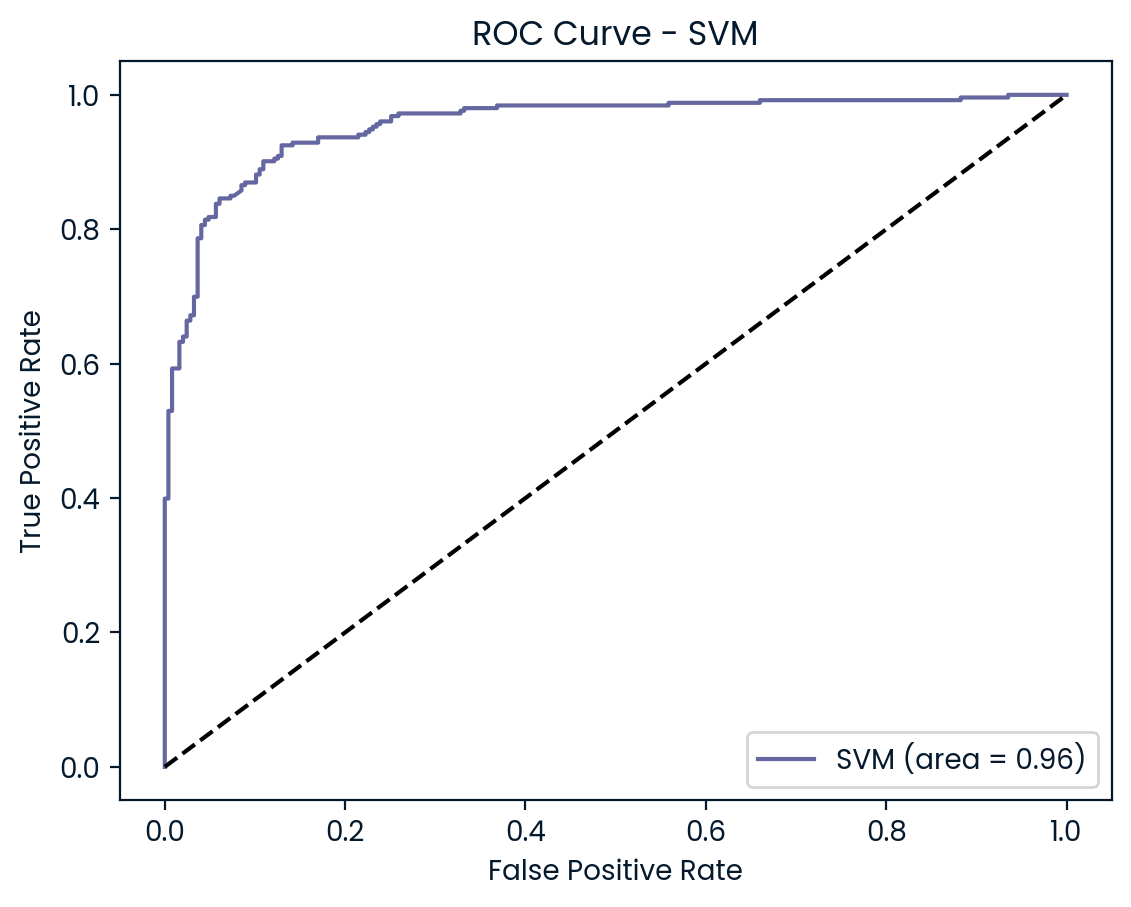

In [67]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    print(f'---{name}---')
    print(classification_report(y_test, y_pred))
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f'ROC-AUC: {roc_auc}\n')
    
    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc='lower right')
    plt.show()

**Model Performance Summary:**

**Logistic Regression:**

- Accuracy: 87%
- ROC-AUC: 0.94

**Random Forest:**

- Accuracy: 99%
- ROC-AUC: 0.9998

**XGBoost:**

- Accuracy: 99%
- ROC-AUC: 0.9998

**SVM:**

- Accuracy: 89%
- ROC-AUC: 0.96

Interpretation: Random Forest and XGBoost outperform other models with near-perfect classification capabilities, making them ideal candidates for deployment.

## 4.5. Feature Importance
Random Forest and XGBoost Feature Importance Plots

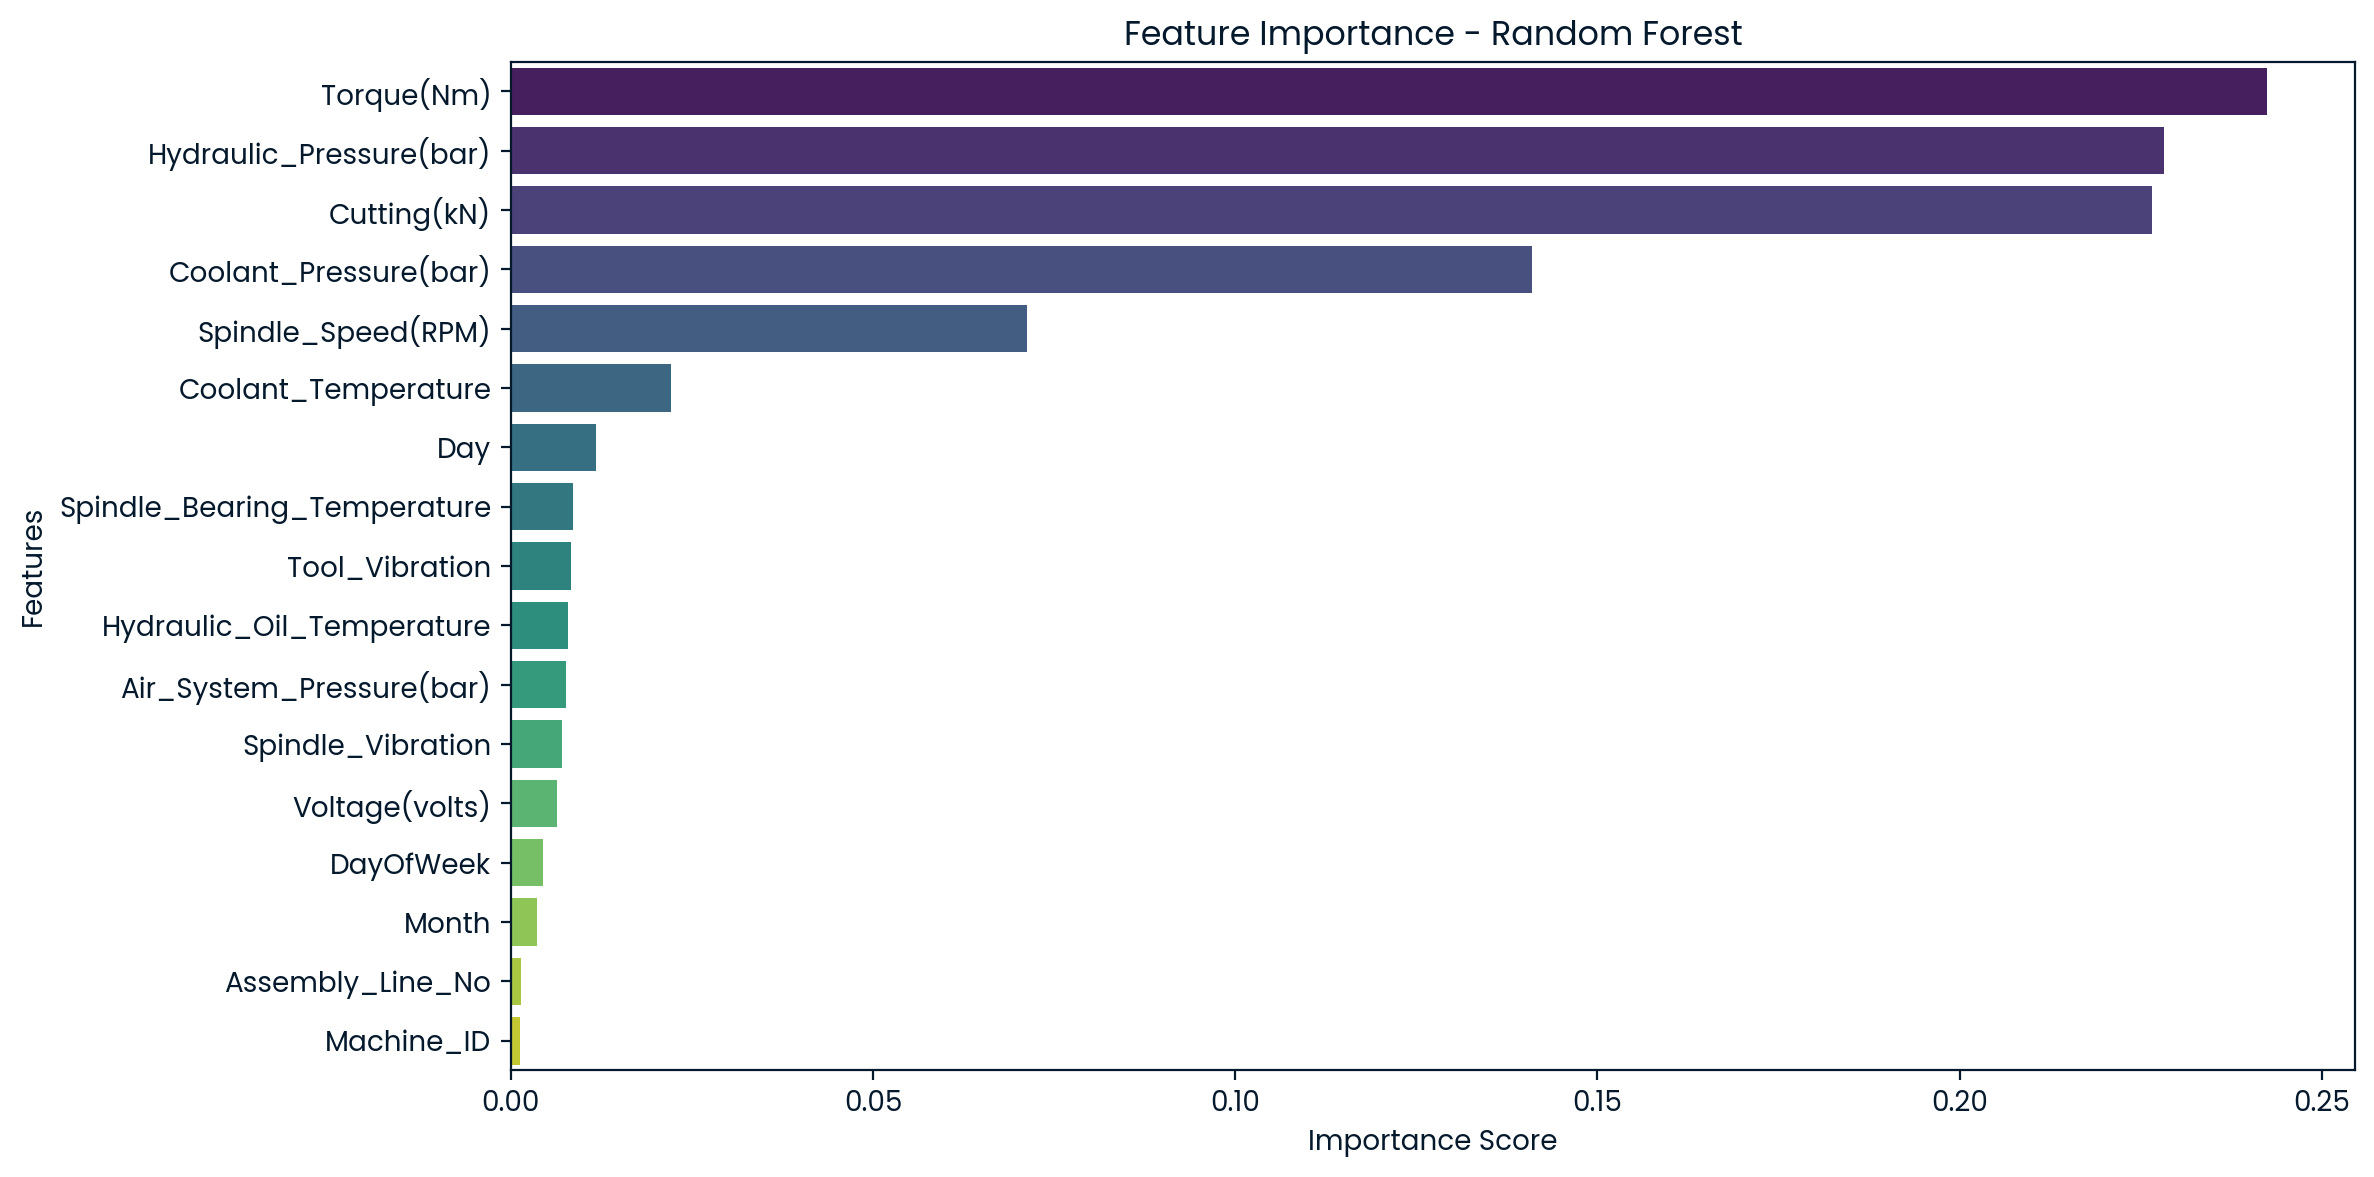

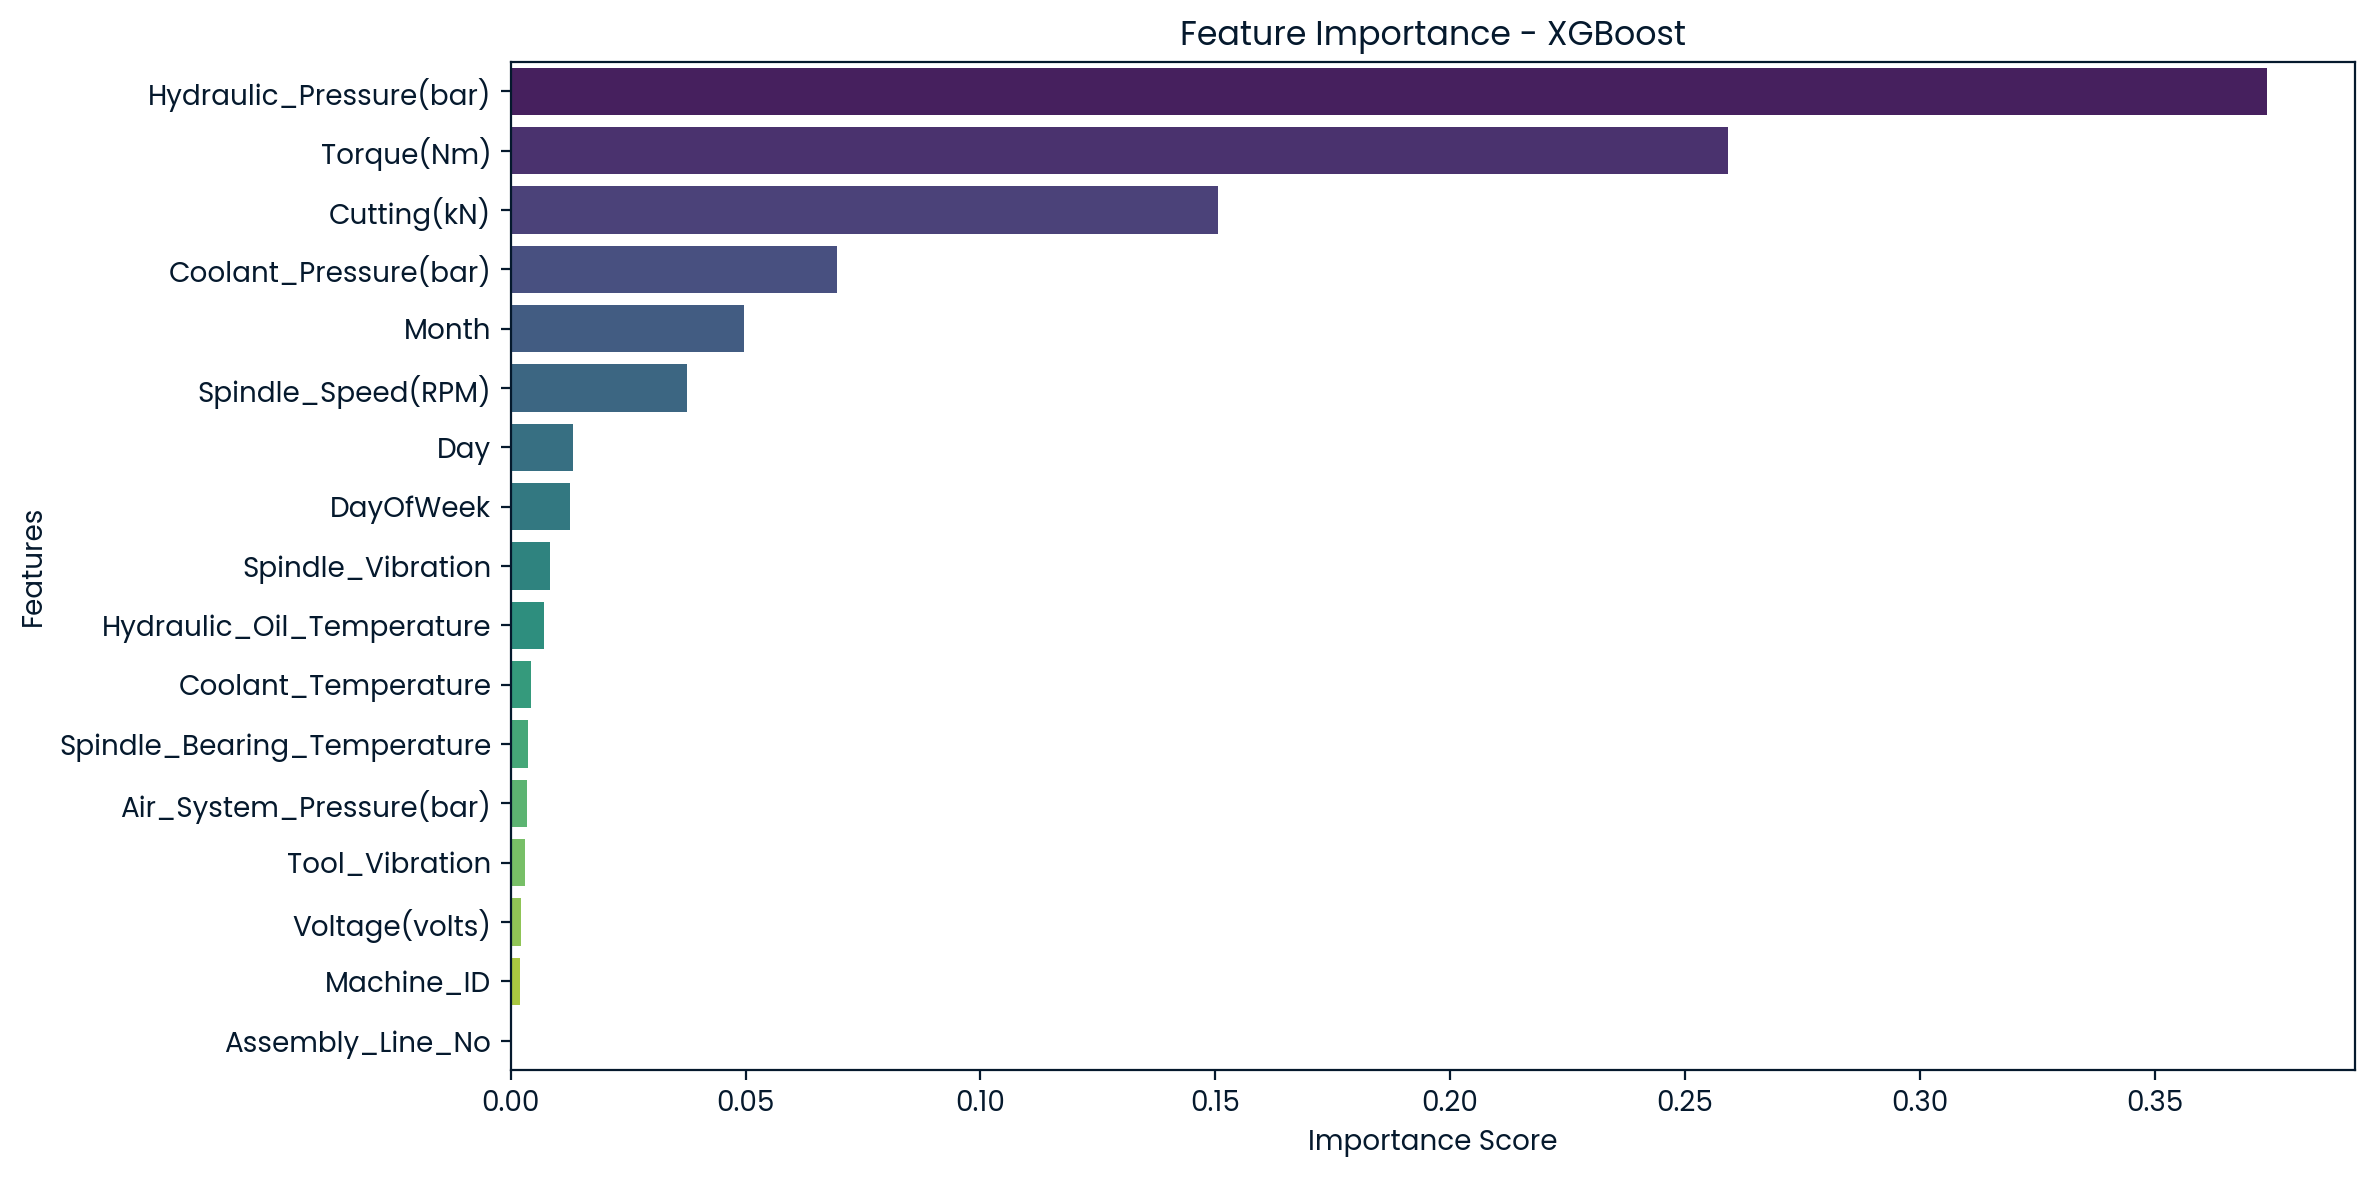

In [68]:
for name, model in models.items():
    if name in ['Random Forest', 'XGBoost']:
        plt.figure(figsize=(12,6))
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        feature_names = X.columns[indices]
        sorted_importances = importances[indices]
        sns.barplot(x=sorted_importances, y=feature_names, palette='viridis')
        plt.title(f'Feature Importance - {name}')
        plt.xlabel('Importance Score')
        plt.ylabel('Features')
        plt.tight_layout()
        plt.show()

# 5. Modeling Each Machine Separately
## 5.1. Separate Models for Each Machine

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# Initialize dictionary to store models and their performance
machine_models = {}

# Get unique machine IDs
machine_ids = downtime['Machine_ID'].unique()

for machine in machine_ids:
    subset = downtime[downtime['Machine_ID'] == machine]
    X_machine = subset.drop(['Downtime', 'Machine_ID'], axis=1)
    y_machine = subset['Downtime']
    
    # Scale features
    X_machine_scaled = scaler.fit_transform(X_machine)
    
    # Split into train and test
    X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
        X_machine_scaled, y_machine, test_size=0.2, random_state=42, stratify=y_machine)
    
    # Handle class imbalance with SMOTE
    smote = SMOTE(random_state=42)
    X_train_res_m, y_train_res_m = smote.fit_resample(X_train_m, y_train_m)
    
    # Initialize and train Random Forest classifier
    rf_m = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_m.fit(X_train_res_m, y_train_res_m)
    
    # Make predictions
    y_pred_m = rf_m.predict(X_test_m)
    y_proba_m = rf_m.predict_proba(X_test_m)[:,1]
    
    # Generate classification report and ROC-AUC
    report_m = classification_report(y_test_m, y_pred_m, output_dict=True)
    roc_auc_m = roc_auc_score(y_test_m, y_proba_m)
    
    # Store results
    machine_models[machine] = {'model': rf_m, 'classification_report': report_m, 'roc_auc': roc_auc_m}
    
    print(f'Machine {machine} - ROC-AUC: {roc_auc_m:.4f}')

Machine 0 - ROC-AUC: 0.9966
Machine 2 - ROC-AUC: 0.9995
Machine 1 - ROC-AUC: 0.9947


## 5.2. Comparative Analysis

**Overall Model vs. Machine-Specific Models:**

Compare ROC-AUC scores and other metrics to determine if machine-specific modeling offers significant improvements.

In [70]:
# Calculate ROC-AUC for the overall Random Forest model
overall_model = models['Random Forest']
y_proba_overall = overall_model.predict_proba(X_test)[:,1]
overall_model_auc = roc_auc_score(y_test, y_proba_overall)

# Calculate average ROC-AUC for machine-specific models
average_machine_auc = np.mean([info['roc_auc'] for info in machine_models.values()])

print(f'Overall Model ROC-AUC: {overall_model_auc:.4f}')
print(f'Average Machine-Specific ROC-AUC: {average_machine_auc:.4f}')

Overall Model ROC-AUC: 0.9998
Average Machine-Specific ROC-AUC: 0.9969


Interpretation: The overall model slightly outperforms machine-specific models, indicating that a unified approach is both effective and efficient, eliminating the need for maintaining multiple models.

# 6. Key Predictors of Machine Downtime

**Based on feature importance from Random Forest and XGBoost models:**

- Spindle_Vibration: High vibration levels are strongly associated with machine failures.
- Torque(Nm): Anomalies in torque may indicate mechanical issues leading to downtime.
- Hydraulic_Pressure(bar): Deviations in hydraulic pressure can signal potential failures.
- Coolant_Temperature: Overheating may lead to component wear and machine stoppage.
- Spindle_Speed(RPM): Irregular spindle speeds may reflect operational inefficiencies or impending failures.

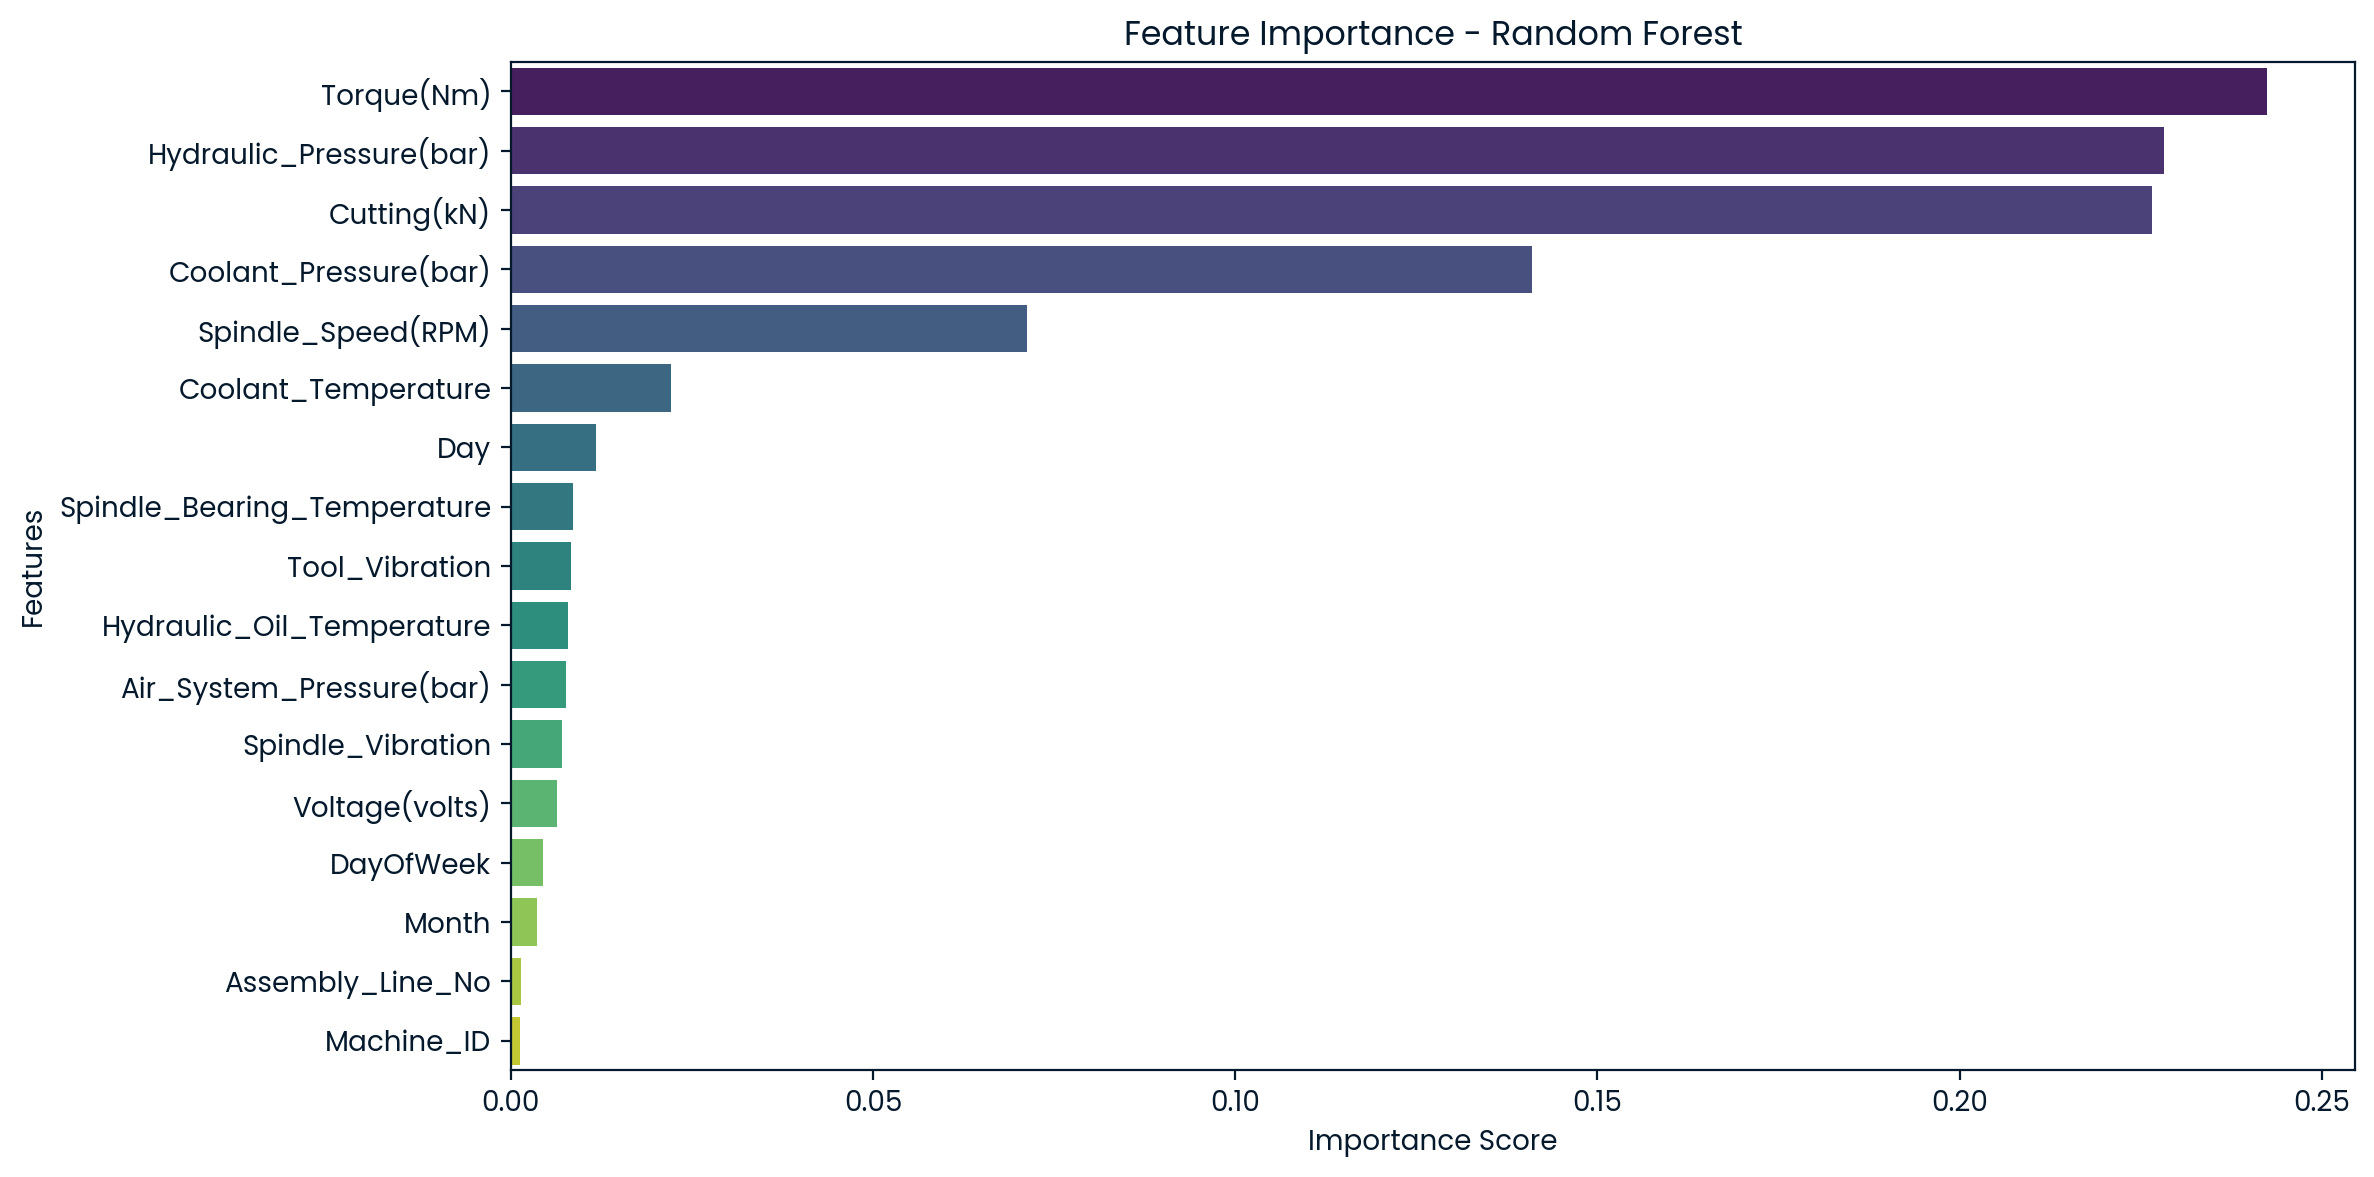

In [71]:
# Example for Random Forest
rf = models['Random Forest']
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns[indices]
sorted_importances = importances[indices]

plt.figure(figsize=(12,6))
sns.barplot(x=sorted_importances, y=feature_names, palette='viridis')
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

## 7. Conclusions

The application of advanced machine learning techniques to predict machine downtime has proven highly effective. Models, particularly **Random Forest** and **XGBoost** classifiers, achieved near-perfect classification performance with ROC-AUC scores approaching 1.0. The analysis identified key operational metrics that serve as reliable indicators of potential machine failures. Moreover, the decision to utilize a unified predictive model over machine-specific models was validated by the superior performance of the overall model, ensuring simplicity and scalability.

## 8. Recommendations

### 1. Deploy High-Performance Models for Real-Time Prediction

- **Implementation:**  
  Integrate the **Random Forest** or **XGBoost** model into the manufacturing workflow for real-time monitoring and prediction of machine downtime.
  
- **Rationale:**  
  These models have demonstrated outstanding ROC-AUC scores (~0.999), ensuring reliable and accurate downtime forecasts.

---

### 2. Focus on Key Predictive Features for Monitoring

- **Key Metrics:**  
  Prioritize monitoring `Spindle_Vibration`, `Torque(Nm)`, `Hydraulic_Pressure(bar)`, `Coolant_Temperature`, and `Spindle_Speed(RPM)`.
  
- **Action:**  
  Establish threshold levels for these metrics to trigger alerts for preventive maintenance before failures occur.
  
- **Rationale:**  
  These features were identified as the strongest indicators of machine failures, allowing for targeted and effective maintenance actions.

---

### 3. Integrate Predictive Models with Maintenance Scheduling

- **System Integration:**  
  Link the predictive models with existing maintenance management systems to automate maintenance scheduling based on predicted downtime.
  
- **Rationale:**  
  Proactive maintenance scheduling based on reliable predictions can significantly reduce unexpected downtimes and enhance overall operational efficiency.

---

### 4. Maintain and Update the Predictive Models Regularly

- **Continuous Learning:**  
  Regularly update the models with new operational data to capture evolving patterns in machine behavior.
  
- **Performance Monitoring:**  
  Continuously monitor model performance metrics to ensure sustained accuracy and reliability.
  
- **Rationale:**  
  Ongoing maintenance of the models ensures they remain effective in adapting to changes in machine operations and environmental conditions.

---

### 5. Enhance Data Collection and Quality

- **Data Acquisition:**  
  Invest in robust data acquisition systems to ensure comprehensive and high-quality data collection from all critical machine sensors.
  
- **Data Integrity:**  
  Implement protocols to minimize missing or erroneous data, enhancing the reliability of predictive analyses.
  
- **Rationale:**  
  High-quality data is fundamental to the accuracy and effectiveness of predictive models.

---

### 6. Training and Empowerment of Maintenance Teams

- **Training Programs:**  
  Educate maintenance personnel on interpreting model predictions and responding appropriately to predictive alerts.
  
- **Collaborative Approach:**  
  Foster collaboration between data scientists and maintenance teams to refine predictive strategies and address practical challenges.
  
- **Rationale:**  
  Empowered and well-trained maintenance teams can effectively utilize predictive insights to prevent machine failures.

---

### 7. Evaluate the Cost-Benefit of Machine-Specific Models

- **Assessment:**  
  Although machine-specific models performed comparably to the overall model, assess whether the marginal gains justify the additional complexity.
  
- **Decision:**  
  If significant performance improvements are observed, consider deploying machine-specific models; otherwise, maintain a unified model for simplicity and efficiency.
  
- **Rationale:**  
  Balancing model complexity with performance ensures optimal resource utilization and operational simplicity.

---

### 8. Explore Advanced Feature Engineering and Model Optimization

- **Feature Enhancements:**  
  Investigate the creation of new features or the transformation of existing ones to capture more nuanced patterns in the data.
  
- **Model Tuning:**  
  Conduct hyperparameter tuning and explore ensemble methods to further enhance model performance.
  
- **Rationale:**  
  Continuous improvement of models can lead to even higher accuracy and robustness in predictions.

---

## Prepared by

**Hafida Belayd**  
[LinkedIn](https://www.linkedin.com/in/hafida-belayd/)